In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df=pd.read_csv(r'/content/ambient_temperature_system_failure.csv')
df.head()

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551


In [2]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from scipy import stats
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')


In [3]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True)

df.head()

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  7267 non-null   datetime64[ns]
 1   value      7267 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 113.7 KB


In [6]:
df.isnull().mean()*100

,0
timestamp,0.0
value,0.0


In [7]:
scaler = StandardScaler()
df['value_scaled'] = scaler.fit_transform(df[['value']]).flatten()

In [8]:
df.describe()

,timestamp,value,value_scaled
count,7267,7267.000000,7.267000e+03
mean,2013-12-17 01:43:01.477914112,71.242433,7.352802e-16
min,2013-07-04 00:00:00,57.458406,-3.245426e+00
25%,2013-10-01 13:30:00,68.369411,-6.764482e-01
50%,2013-12-19 04:00:00,71.858493,1.450503e-01
75%,2014-03-06 01:30:00,74.430958,7.507328e-01
max,2014-05-28 15:00:00,86.223213,3.527199e+00
std,NaN,4.247509,1.000069e+00


In [9]:
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month

In [10]:
window_sizes = [6, 12, 24]  # 6h, 12h, 24h windows
for window in window_sizes:
    df[f'rolling_mean_{window}h'] = df['value'].rolling(window=window, center=True).mean()
    df[f'rolling_std_{window}h'] = df['value'].rolling(window=window, center=True).std()
    df[f'rolling_median_{window}h'] = df['value'].rolling(window=window, center=True).median()


In [11]:
df['value_diff'] = df['value'].diff()
df['value_diff_2'] = df['value'].diff(2)

In [12]:
df = df.bfill().ffill()

In [13]:
df.shape

(7267, 17)

In [14]:
feature_cols = ['value_scaled', 'hour', 'day_of_week', 'month'] + \
               [col for col in df.columns if 'rolling' in col] + \
               ['value_diff', 'value_diff_2']


In [15]:
X = df[feature_cols].values
timestamps = df['timestamp'].values
original_values = df['value'].values

In [17]:
methods = {
    'Isolation Forest': IsolationForest(
        contamination=0.05,
        random_state=42,
        n_estimators=200,
        max_samples=0.8
    ),
    'One-Class SVM': OneClassSVM(
        nu=0.05,
        kernel='rbf',
        gamma='scale'
    ),

    'DBSCAN': DBSCAN(
        eps=0.5,
        min_samples=10
    )
}

In [20]:
def statistical_anomaly_detection(values, threshold=3):

    z_scores = np.abs(stats.zscore(values))
    return z_scores > threshold

def iqr_anomaly_detection(values, factor=1.5):

    Q1 = np.percentile(values, 25)
    Q3 = np.percentile(values, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    return (values < lower_bound) | (values > upper_bound)

In [18]:
results = {}
anomaly_scores = {}


for name, method in methods.items():
    print(f"Running {name}...")

    if name == 'DBSCAN':
        labels = method.fit_predict(X)
        anomalies = labels == -1
        # Create pseudo-scores
        scores = np.ones(len(X))
        scores[anomalies] = 2.0
    else:
        method.fit(X)
        anomalies = method.predict(X) == -1


        if hasattr(method, 'decision_function'):
            scores = -method.decision_function(X)  # Negative for anomalies
        elif hasattr(method, 'score_samples'):
            scores = -method.score_samples(X)
        else:
            scores = np.ones(len(X))
            scores[anomalies] = 2.0

    results[name] = anomalies
    anomaly_scores[name] = scores
    print(f"  Detected {np.sum(anomalies)} anomalies ({100*np.sum(anomalies)/len(anomalies):.2f}%)")


Running Isolation Forest...
  Detected 364 anomalies (5.01%)
Running One-Class SVM...
  Detected 364 anomalies (5.01%)
Running DBSCAN...
  Detected 7267 anomalies (100.00%)


Running Statistical Methods...

In [21]:
z_anomalies = statistical_anomaly_detection(original_values, threshold=2.5)
results['Z-Score'] = z_anomalies
anomaly_scores['Z-Score'] = np.abs(stats.zscore(original_values))
print(f"  Z-Score: Detected {np.sum(z_anomalies)} anomalies ({100*np.sum(z_anomalies)/len(z_anomalies):.2f}%)")


iqr_anomalies = iqr_anomaly_detection(original_values, factor=1.5)
results['IQR'] = iqr_anomalies

Q1, Q3 = np.percentile(original_values, [25, 75])
IQR = Q3 - Q1
iqr_scores = np.maximum(
    np.abs(original_values - Q1) / IQR,
    np.abs(original_values - Q3) / IQR
)
anomaly_scores['IQR'] = iqr_scores
print(f"  IQR: Detected {np.sum(iqr_anomalies)} anomalies ({100*np.sum(iqr_anomalies)/len(iqr_anomalies):.2f}%)")


print("\nCreating Ensemble Method...")
vote_matrix = np.column_stack([results[method].astype(int) for method in results.keys()])
ensemble_votes = np.sum(vote_matrix, axis=1)
# Consider anomaly if at least 3 methods agree
ensemble_threshold = 3
ensemble_anomalies = ensemble_votes >= ensemble_threshold
results['Ensemble (≥3 votes)'] = ensemble_anomalies
anomaly_scores['Ensemble (≥3 votes)'] = ensemble_votes
print(f"  Ensemble: Detected {np.sum(ensemble_anomalies)} anomalies ({100*np.sum(ensemble_anomalies)/len(ensemble_anomalies):.2f}%)")


  Z-Score: Detected 99 anomalies (1.36%)
  IQR: Detected 35 anomalies (0.48%)

Creating Ensemble Method...
  Ensemble: Detected 233 anomalies (3.21%)


In [22]:
def evaluate_method(anomalies, scores, values):
    """Evaluate anomaly detection method"""
    n_anomalies = np.sum(anomalies)
    anomaly_rate = n_anomalies / len(anomalies)

    # Calculate statistics for detected anomalies
    if n_anomalies > 0:
        anomaly_values = values[anomalies]
        normal_values = values[~anomalies]

        # Separation quality (how different anomalies are from normal)
        if len(normal_values) > 0:
            separation = np.abs(np.mean(anomaly_values) - np.mean(normal_values)) / np.std(values)
        else:
            separation = 0

        # Score consistency (higher scores should correspond to more extreme anomalies)
        score_consistency = np.corrcoef(scores, np.abs(values - np.mean(values)))[0, 1]
        if np.isnan(score_consistency):
            score_consistency = 0
    else:
        separation = 0
        score_consistency = 0

    # Temporal clustering (anomalies should be somewhat clustered in time)
    if n_anomalies > 1:
        anomaly_indices = np.where(anomalies)[0]
        time_gaps = np.diff(anomaly_indices)
        temporal_clustering = 1 / (1 + np.std(time_gaps))
    else:
        temporal_clustering = 0

    return {
        'n_anomalies': n_anomalies,
        'anomaly_rate': anomaly_rate,
        'separation': separation,
        'score_consistency': score_consistency,
        'temporal_clustering': temporal_clustering
    }

In [24]:
method_evaluations = {}
for method_name in results.keys():
    evaluation = evaluate_method(
        results[method_name],
        anomaly_scores[method_name],
        original_values
    )
    method_evaluations[method_name] = evaluation

    print(f"{method_name:<20} {evaluation['n_anomalies']:<8} "
          f"{evaluation['anomaly_rate']*100:<8.2f} {evaluation['separation']:<12.3f} "
          f"{evaluation['score_consistency']:<12.3f} {evaluation['temporal_clustering']:<12.3f}")

print("\nSelecting Best Method...")
composite_scores = {}
for method_name, eval_data in method_evaluations.items():
    rate_score = 1 - abs(eval_data['anomaly_rate'] - 0.05) * 10  # Penalty for being far from 5%
    rate_score = max(0, rate_score)

    composite = (
        0.3 * rate_score +
        0.3 * eval_data['separation'] +
        0.2 * abs(eval_data['score_consistency']) +
        0.2 * eval_data['temporal_clustering']
    )
    composite_scores[method_name] = composite

best_method = max(composite_scores.items(), key=lambda x: x[1])
print(f"\nBest Method: {best_method[0]} (Score: {best_method[1]:.3f})")

best_anomalies = results[best_method[0]]
best_scores = anomaly_scores[best_method[0]]
best_evaluation = method_evaluations[best_method[0]]

Isolation Forest     364      5.01     0.585        0.649        0.009       
One-Class SVM        364      5.01     0.240        0.800        0.007       
DBSCAN               7267     100.00   0.000        0.000        1.000       
Z-Score              99       1.36     1.071        1.000        0.004       
IQR                  35       0.48     0.472        0.998        0.002       
Ensemble (≥3 votes)  233      3.21     0.396        0.559        0.004       

Selecting Best Method...

Best Method: Z-Score (Score: 0.713)


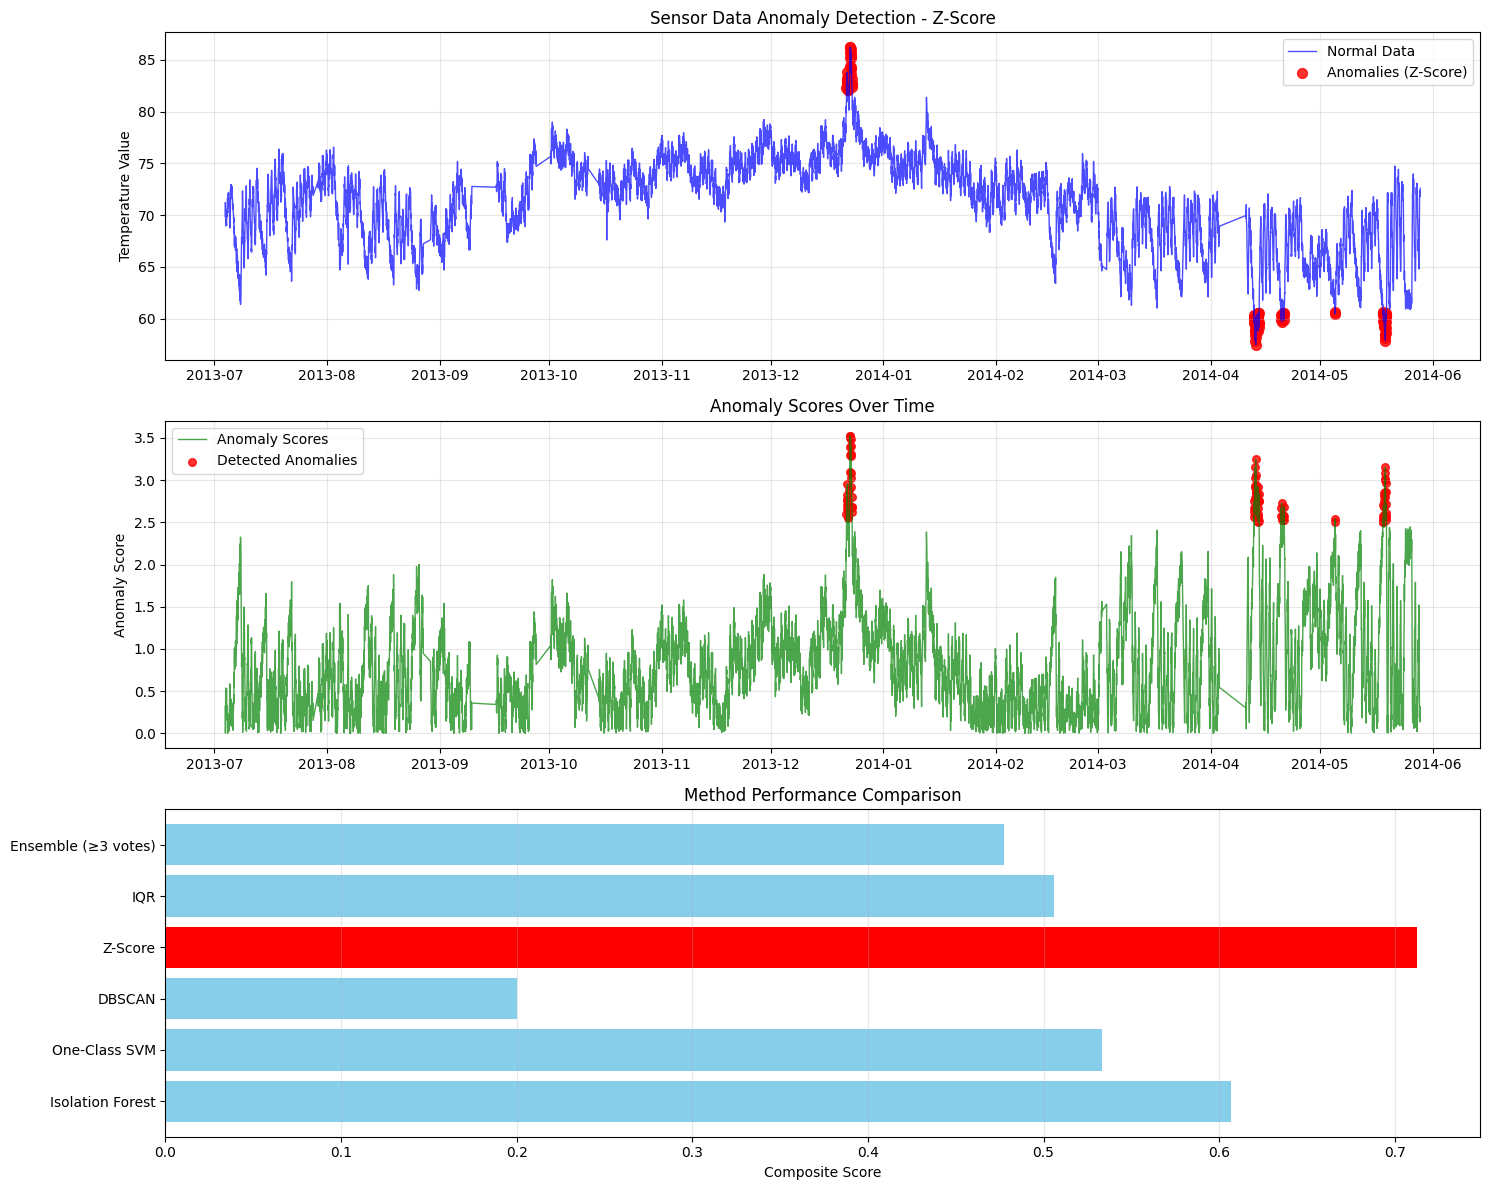

In [25]:
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

axes[0].plot(timestamps, original_values, 'b-', alpha=0.7, linewidth=1, label='Normal Data')
axes[0].scatter(timestamps[best_anomalies], original_values[best_anomalies],
                c='red', s=50, alpha=0.8, label=f'Anomalies ({best_method[0]})')
axes[0].set_title(f'Sensor Data Anomaly Detection - {best_method[0]}')
axes[0].set_ylabel('Temperature Value')
axes[0].legend()
axes[0].grid(True, alpha=0.3)


axes[1].plot(timestamps, best_scores, 'g-', alpha=0.7, linewidth=1, label='Anomaly Scores')
axes[1].scatter(timestamps[best_anomalies], best_scores[best_anomalies],
                c='red', s=30, alpha=0.8, label='Detected Anomalies')
axes[1].set_title('Anomaly Scores Over Time')
axes[1].set_ylabel('Anomaly Score')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

method_names = list(composite_scores.keys())
scores = list(composite_scores.values())
colors = ['red' if name == best_method[0] else 'skyblue' for name in method_names]

axes[2].barh(range(len(method_names)), scores, color=colors)
axes[2].set_yticks(range(len(method_names)))
axes[2].set_yticklabels(method_names)
axes[2].set_xlabel('Composite Score')
axes[2].set_title('Method Performance Comparison')
axes[2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

In [26]:
print(f"Data points: {len(df)}")
print(f"Time range: {timestamps[0]} to {timestamps[-1]}")
print(f"\nBest Method: {best_method[0]}")
print(f"Composite Score: {best_method[1]:.3f}")
print(f"\nAnomalies Detected: {best_evaluation['n_anomalies']}")
print(f"Anomaly Rate: {best_evaluation['anomaly_rate']*100:.2f}%")
print(f"Separation Quality: {best_evaluation['separation']:.3f}")
print(f"Score Consistency: {best_evaluation['score_consistency']:.3f}")


Data points: 7267
Time range: 2013-07-04T00:00:00.000000000 to 2014-05-28T15:00:00.000000000

Best Method: Z-Score
Composite Score: 0.713

Anomalies Detected: 99
Anomaly Rate: 1.36%
Separation Quality: 1.071
Score Consistency: 1.000


In [27]:
print(f"\nDetected Anomalous Data Points:")
print("-" * 40)
anomaly_data = df[best_anomalies][['timestamp', 'value']].reset_index(drop=True)
for i, row in anomaly_data.iterrows():
    print(f"{i+1:2d}. {row['timestamp']} - Value: {row['value']:.3f}")

output_df = df.copy()
output_df['is_anomaly'] = best_anomalies
output_df['anomaly_score'] = best_scores
output_df['method_used'] = best_method[0]

print(f"\nSaving results to 'anomaly_detection_results.csv'...")
output_df[['timestamp', 'value', 'is_anomaly', 'anomaly_score', 'method_used']].to_csv(
    'anomaly_detection_results.csv', index=False
)



Detected Anomalous Data Points:
----------------------------------------
 1. 2013-12-21 20:00:00 - Value: 82.289
 2. 2013-12-21 21:00:00 - Value: 82.990
 3. 2013-12-21 22:00:00 - Value: 83.248
 4. 2013-12-21 23:00:00 - Value: 82.520
 5. 2013-12-22 00:00:00 - Value: 82.737
 6. 2013-12-22 01:00:00 - Value: 83.781
 7. 2013-12-22 02:00:00 - Value: 83.009
 8. 2013-12-22 03:00:00 - Value: 82.816
 9. 2013-12-22 05:00:00 - Value: 82.454
10. 2013-12-22 06:00:00 - Value: 82.092
11. 2013-12-22 09:00:00 - Value: 82.111
12. 2013-12-22 16:00:00 - Value: 83.512
13. 2013-12-22 17:00:00 - Value: 84.391
14. 2013-12-22 18:00:00 - Value: 85.228
15. 2013-12-22 19:00:00 - Value: 86.095
16. 2013-12-22 20:00:00 - Value: 86.204
17. 2013-12-22 21:00:00 - Value: 86.223
18. 2013-12-22 22:00:00 - Value: 85.649
19. 2013-12-22 23:00:00 - Value: 86.075
20. 2013-12-23 00:00:00 - Value: 85.326
21. 2013-12-23 01:00:00 - Value: 85.706
22. 2013-12-23 02:00:00 - Value: 84.087
23. 2013-12-23 03:00:00 - Value: 85.222
24. 20